# Imports and Settings

In [140]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")


# Dataset

In [141]:
simulation_output = "../simulation_output/summary_output.csv"

df = pd.read_csv(simulation_output, index_col=0)

# Flatten nested data
algo_params_df = df["algorithm_params"].astype('str')
algo_params_df = algo_params_df.apply(lambda x: ast.literal_eval(x))
algo_params_df = algo_params_df.apply(pd.Series)
df = df.drop(columns=['algorithm_params'])
df = pd.concat([df, algo_params_df], axis=1)


# Remove duplicates
df = df.drop_duplicates(subset=df.columns.difference(['avg_elapsed_time']))


# Parameter Groups

In [142]:
graph_params = [
    "num_locations",
    "min_location_distance",
    "grid_size",
    "avg_vehicle_speed",
    "clusters"
]

passenger_params = [
    "num_passengers",
    "beta_distribution",
    "preference_distribution",
    "service_hours",
    "inter_cluster_travelling"
]

greedy_insert_params = [
    'algorithm',
    "iterations",
    "final_voting_rule"
]

iterative_voting_params = [
    'algorithm',
    "iterative_voting_rule",
    "final_voting_rule"
]

util_columns = [
    "avg_proportionality",
    "avg_utility",
    "avg_utilitarian",
    "avg_egalitarian"
]

# Graph Structures

In [143]:
graph_strucutre_1 = {
    "avg_vehicle_speed": 30,
    "clusters": 4,
    "grid_size": 7000,
    "min_location_distance": 400,
    "num_locations": 150
}

graph_structure_2 = {
    "To-Do": None
}

graph_structures = [graph_strucutre_1, graph_structure_2]


# Helper Functions

In [144]:
def df_by_graph_structure(df, structure):
    new_df = df.copy()
    for key in structure:
        new_df = (new_df[new_df[key] == structure[key]])
    
    return new_df

def df_by_settings(df, structure):
    new_df = df.copy()
    for key in structure:
        new_df = (new_df[new_df[key] == structure[key]])
    
    return new_df

def format_settings(setting):
    formatted_settings = \
        [setting for setting in map(str, list(setting.items()))]
    return "\n".join(formatted_settings)


# Simulation Results

## 1. Algorithm Comparison

### Simulation Setting

In [145]:
env_settings = {
    "avg_vehicle_speed": 30,
    "clusters": 4,
    "grid_size": 7000,
    "min_location_distance": 400,
    "num_locations": 150
}

greedy_algo_setting = {
    "algorithm": "greedy_insert",
    "iterations": 1
}

greedy_df = df_by_settings(df, {**env_settings, **greedy_algo_setting})


algo_groups = []
for name, group in greedy_df.groupby(['final_voting_rule']):
    final_voting_rule = group['final_voting_rule'].iloc[0]
    rule = "" if final_voting_rule == "None" else f"({final_voting_rule})"
    group['algorithm'] = group['algorithm'].transform(lambda x: f"{x} {rule}")
    algo_groups.append(group)

iterative_df = df_by_settings(df, env_settings).query("algorithm == 'iterative_voting_2'")
for name, group in iterative_df.groupby(['iterative_voting_rule']):
    rule = group['iterative_voting_rule'].iloc[0]
    group['algorithm'] = group['algorithm'].transform(lambda x: f"{x} ({rule})")
    algo_groups.append(group)

temp_df = pd.concat(algo_groups)
# temp_df['avg_egalitarian'] = temp_df['avg_egalitarian'] / np.sqrt(np.sum(temp_df['avg_egalitarian'] ** 2))


### Results

('avg_vehicle_speed', 30)
('clusters', 4)
('grid_size', 7000)
('min_location_distance', 400)
('num_locations', 150)


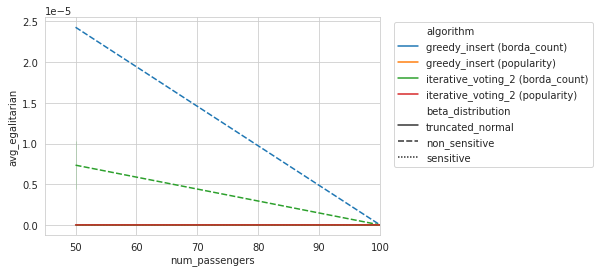

In [146]:
fig, ax = plt.subplots()
print(format_settings({**env_settings}))
ax.set_xlim(45, 100)
sns.lineplot(data=temp_df, ax=ax, x='num_passengers', y='avg_egalitarian', hue="algorithm", style="beta_distribution")
ax.legend(bbox_to_anchor=(1.65, 1.0), loc="upper right", fontsize="medium")
plt.savefig("../../papers/figures/algorithm_comparison_avg_util.png", bbox_inches="tight")


## 2. Impact of Voting Mechanisms on Greedy Insert Algorithm

### Simulation Setting

In [147]:
env_settings = {
    "avg_vehicle_speed": 30,
    "clusters": 4,
    "grid_size": 7000,
    "min_location_distance": 400,
    "num_locations": 150,
    "num_passengers": 200
}

algorithm_settings = {
    "algorithm": "greedy_insert"
}
temp_df = df_by_settings(df, {**env_settings, **algorithm_settings})

### Results

('avg_vehicle_speed', 30)
('clusters', 4)
('grid_size', 7000)
('min_location_distance', 400)
('num_locations', 150)
('num_passengers', 200)
('algorithm', 'greedy_insert')


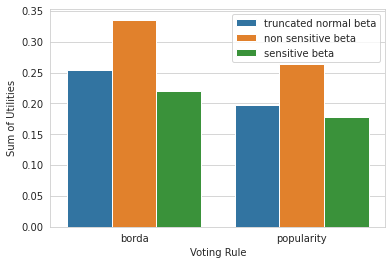

In [148]:
vanilla_greedy = temp_df[temp_df['final_voting_rule'] == "None"]
borda_greedy = temp_df.query(
    '''
    iterations == 100 and \
    final_voting_rule == "borda_count"
    '''
)
popularity_greedy = temp_df.query(
    '''
    iterations == 100 and \
    final_voting_rule == "popularity"
    '''
)

fig, ax = plt.subplots()
print(format_settings({**env_settings, **algorithm_settings}))
greedy_df = pd.concat([borda_greedy, popularity_greedy, vanilla_greedy])
greedy_df = greedy_df.replace({'borda_count': "borda"})
greedy_df = greedy_df.replace({"truncated_normal": "truncated normal beta"})
greedy_df = greedy_df.replace({"non_sensitive": "non sensitive beta"})
greedy_df = greedy_df.replace({"sensitive": "sensitive beta"})
sns.barplot(data=greedy_df, ax=ax, x='final_voting_rule', y='avg_utility', hue="beta_distribution")
ax.set_xlabel("Voting Rule")
ax.set_ylabel("Sum of Utilities")
ax.legend(loc="upper right", fontsize="medium")
fig.savefig("../../papers/figures/greedy_plus.png", bbox_inches="tight")

From the graph above, it can be observed that applying both borda and popularity voting rules increased the sum of utilities of the riders, with borda giving the best performance. This trend is similar under all 3 different types of beta distributions. 

## 3. Impact of Voting Iterations on Greedy Insert

### Settings

In [149]:
env_settings = {
    "avg_vehicle_speed": 30,
    "clusters": 4,
    "grid_size": 7000,
    "min_location_distance": 400,
    "num_passengers": 200
}

algorithm_settings = {
    "algorithm": "greedy_insert",
}

temp_df = df_by_settings(df, {**env_settings, **algorithm_settings})
temp_df = temp_df[temp_df['final_voting_rule'] != "None"]

('avg_vehicle_speed', 30)
('clusters', 4)
('grid_size', 7000)
('min_location_distance', 400)
('num_passengers', 200)
('algorithm', 'greedy_insert')


23

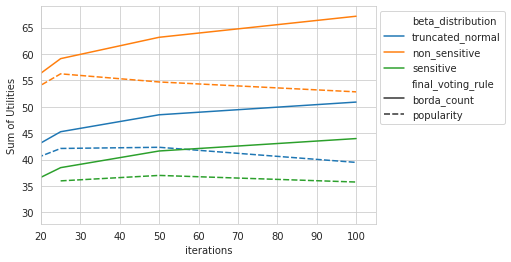

In [150]:
fig, ax = plt.subplots()
(format_settings({**env_settings, **algorithm_settings}))
ax.set_xlim(20, 105)
sns.lineplot(data=temp_df, ax=ax, x='iterations', y='avg_utilitarian', hue="beta_distribution", style="final_voting_rule")
ax.legend(bbox_to_anchor=(1.40, 1.0), loc="upper right", fontsize="medium")
ax.set_ylabel('Sum of Utilities')
len(temp_df.sort_values('beta_distribution'))

From the graph, we can see that the borda count method improved the sum of utilities of the riders as the number of iterations (number of solution candidates) increases. For the case of popularity voting, the sum of utilities had an overall decline as the number of iterations (number of candidates) increases. The trend is similar for all 3 beta distributions as well.

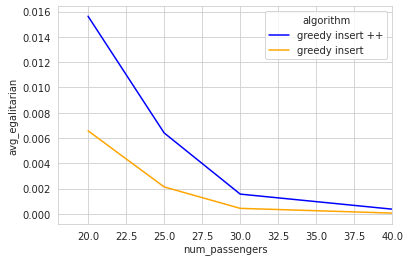

In [217]:
env_settings = {
    "avg_vehicle_speed": 19.76,
    "clusters": 4,
    "grid_size": 7000,
    "min_location_distance": 600,
    "num_locations": 65,
    "beta_distribution": "non_sensitive"
}

algorithm_settings = {
    "objective": "egalitarian",
    "iterations": 50
}

temp_df = df_by_settings(df, {**env_settings, **algorithm_settings})
algo_groups = []
lgo_groups = []
for name, group in temp_df.groupby(['final_voting_rule']):
    final_voting_rule = group['final_voting_rule'].iloc[0]
    rule = "" if final_voting_rule == "None" else f"({final_voting_rule})"
    if not final_voting_rule == "borda_count":
        algo_groups.append(group)


temp_df = pd.concat(algo_groups)
mask_1 = temp_df['algorithm'] == 'greedy_insert'
mask_2 = temp_df['algorithm'] == 'greedy_insert_2'

temp_df.loc[mask_1, 'algorithm'] = 'greedy insert'
temp_df.loc[mask_2, 'algorithm'] = 'greedy insert ++'
fig, ax = plt.subplots()
sns.lineplot(data=temp_df, ax=ax, x='num_passengers', y='avg_egalitarian', hue="algorithm", palette=['blue', 'orange'])
ax.set_xlim(18, 40)
plt.savefig("../../papers/figures/algorithm_comparison_avg_egalitarian.png", bbox_inches="tight")

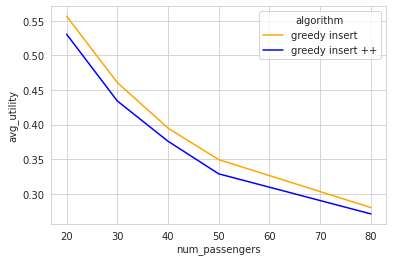

In [216]:
env_settings = {
    "avg_vehicle_speed": 19.76,
    "clusters": 4,
    "grid_size": 7000,
    "min_location_distance": 600,
    "num_locations": 65
}

algorithm_settings = {
    "objective": "utilitarian",
    "iterations": 50
}

temp_df = df_by_settings(df, {**env_settings, **algorithm_settings})

algo_groups = []
for name, group in temp_df.groupby(['final_voting_rule']):
    final_voting_rule = group['final_voting_rule'].iloc[0]
    rule = "" if final_voting_rule == "None" else f"({final_voting_rule})"
    if not final_voting_rule == "borda_count":
        algo_groups.append(group)



temp_df = pd.concat(algo_groups)
temp_df = pd.concat(algo_groups)
mask_1 = temp_df['algorithm'] == 'greedy_insert'
mask_2 = temp_df['algorithm'] == 'greedy_insert_2'

temp_df.loc[mask_1, 'algorithm'] = 'greedy insert'
temp_df.loc[mask_2, 'algorithm'] = 'greedy insert ++'
fig, ax = plt.subplots()
sns.lineplot(data=temp_df, ax=ax, x='num_passengers', y='avg_utility', hue="algorithm", palette=['orange', 'blue'])
plt.savefig("../../papers/figures/algorithm_comparison_avg_util.png", bbox_inches="tight")
